In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],70, 70, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 2, 0.5
        yi, yi2 = 1e-5, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 2, 0.5
        yi, yi2 = 1e-16, 1e-16
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_csv("/home/zhy/Zhou/lm/wine/winequality-white.csv", sep=';') 

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=5880, step=1400,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=5880, step=1400,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=5880, step=1400,bd_tol=1,zone=2/3)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=5880, step=1400,bd_tol=1,zone=2/3)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

[[0.13787014]
 [0.13787014]
 [0.13787014]
 ...
 [0.13787014]
 [1.2671142 ]
 [0.13787014]]
torch.Size([4898, 11])
model # of parameters: 5880


<ipython-input-1-50cc98984735>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-1-50cc98984735>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

[1] Reject
[2] Reject
[3] Accept | Loss = 1.098271 -> 1.012368 | parameter #: 5880| time: 421.2428894042969
[4] Accept | Loss = 1.012368 -> 0.970619 | parameter #: 5880| time: 563.9188232421875
[5] Accept | Loss = 0.970619 -> 0.912631 | parameter #: 5880| time: 710.9591064453125
[6] Reject
[7] Accept | Loss = 0.912631 -> 0.856032 | parameter #: 5880| time: 989.317138671875
[8] Reject
[9] Accept | Loss = 0.856032 -> 0.809332 | parameter #: 5880| time: 1279.405029296875
[10] Reject
[11] Accept | Loss = 0.809332 -> 0.776196 | parameter #: 5880| time: 1559.9349365234375
[12] Accept | Loss = 0.776196 -> 0.745291 | parameter #: 5880| time: 1708.653564453125
[13] Reject
[14] Accept | Loss = 0.745291 -> 0.730278 | parameter #: 5880| time: 1974.2730712890625
[15] Accept | Loss = 0.730278 -> 0.722062 | parameter #: 5880| time: 2113.21435546875
[16] Accept | Loss = 0.722062 -> 0.718164 | parameter #: 5880| time: 2266.018798828125
[17] Accept | Loss = 0.718164 -> 0.713788 | parameter #: 5880| time

<ipython-input-1-50cc98984735>:103: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647369228/work/aten/src/ATen/native/TensorShape.cpp:3683.)
  correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)


[15] Accept | Loss = 1.919279 -> 1.069353 | parameter #: 5880| time: 2056.038330078125
optnumber 5880
[16] Accept | Loss = 1.069353 -> 0.982492 | parameter #: 5880| time: 2197.075927734375
[17] Accept | Loss = 0.982492 -> 0.972023 | parameter #: 5880| time: 2353.19921875
[18] Accept | Loss = 0.972023 -> 0.957876 | parameter #: 5880| time: 2488.263671875
[19] Accept | Loss = 0.957876 -> 0.933985 | parameter #: 5880| time: 2627.463134765625
[20] Accept | Loss = 0.933985 -> 0.898489 | parameter #: 5880| time: 2779.28955078125
optnumber 5880
[21] Accept | Loss = 0.898489 -> 0.854327 | parameter #: 5880| time: 2911.3271484375
[22] Reject
[23] Accept | Loss = 0.854327 -> 0.825784 | parameter #: 5880| time: 3185.92724609375
[24] Reject
[25] Accept | Loss = 0.825784 -> 0.805588 | parameter #: 5880| time: 3470.563232421875
optnumber 5880
[26] Accept | Loss = 0.805588 -> 0.780012 | parameter #: 5880| time: 3608.414306640625
[27] Reject
[28] Accept | Loss = 0.780012 -> 0.763579 | parameter #: 588

TypeError: PINN_LM.LM() got an unexpected keyword argument 'zone'

[[0.13787014]
 [0.13787014]
 [0.13787014]
 ...
 [0.13787014]
 [1.2671142 ]
 [0.13787014]]
torch.Size([4898, 11])
model # of parameters: 5880
[1] Reject


<ipython-input-2-3bd1627c78cb>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-2-3bd1627c78cb>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

[2] Accept | Loss = 1.018549 -> 0.950182 | parameter #: 5880| time: 182.29554748535156
[3] Accept | Loss = 0.950182 -> 0.884863 | parameter #: 5880| time: 327.20281982421875
[4] Reject
[5] Accept | Loss = 0.884863 -> 0.829962 | parameter #: 5880| time: 613.1026000976562
[6] Reject
[7] Accept | Loss = 0.829962 -> 0.790180 | parameter #: 5880| time: 898.9061279296875
[8] Accept | Loss = 0.790180 -> 0.752871 | parameter #: 5880| time: 1043.2850341796875
[9] Reject
[10] Accept | Loss = 0.752871 -> 0.734116 | parameter #: 5880| time: 1332.1563720703125
[11] Accept | Loss = 0.734116 -> 0.722974 | parameter #: 5880| time: 1478.7071533203125
[12] Accept | Loss = 0.722974 -> 0.717629 | parameter #: 5880| time: 1624.9876708984375
[13] Accept | Loss = 0.717629 -> 0.712779 | parameter #: 5880| time: 1784.1868896484375
[14] Reject
[15] Reject
[16] Accept | Loss = 0.712779 -> 0.708852 | parameter #: 5880| time: 2219.3818359375
[17] Reject
[18] Accept | Loss = 0.708852 -> 0.704321 | parameter #: 5880

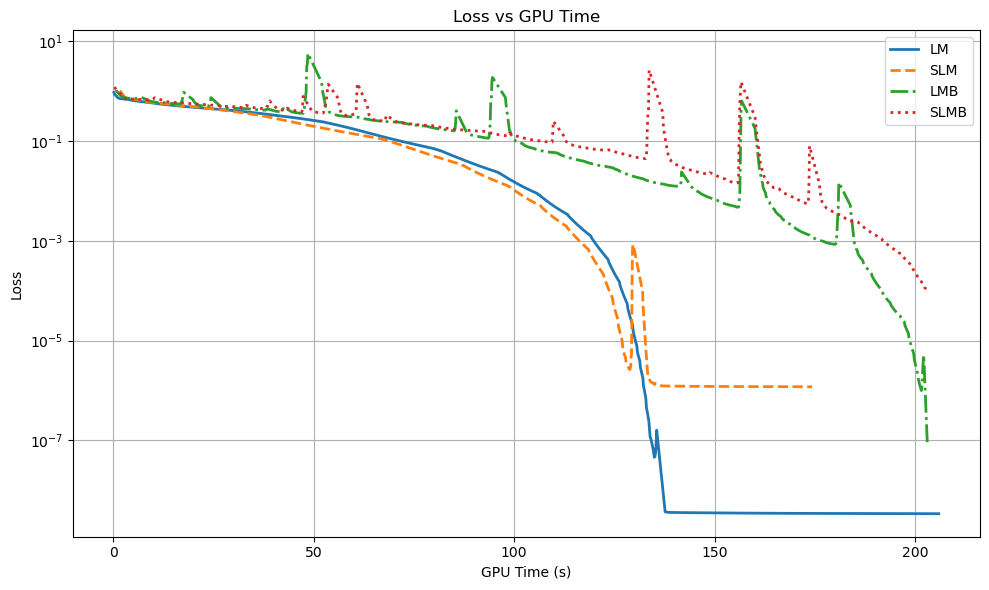

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],70, 70, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 2, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 2, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_csv("/home/zhy/Zhou/lm/wine/winequality-white.csv", sep=';') 

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=5880, step=1400,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=5880, step=1400,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=5880, step=1400,bd_tol=1,zone=2/3)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=5880, step=1400,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

[[0.13787014]
 [0.13787014]
 [0.13787014]
 ...
 [0.13787014]
 [1.2671142 ]
 [0.13787014]]
torch.Size([4898, 11])
model # of parameters: 5880
[1] Accept | Loss = 1.000394 -> 0.943113 | parameter #: 5880| time: 0


<ipython-input-3-3bd1627c78cb>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-3-3bd1627c78cb>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

[2] Reject
[3] Accept | Loss = 0.943113 -> 0.881865 | parameter #: 5880| time: 325.9658203125
[4] Reject
[5] Accept | Loss = 0.881865 -> 0.824235 | parameter #: 5880| time: 606.9104614257812
[6] Reject
[7] Accept | Loss = 0.824235 -> 0.782174 | parameter #: 5880| time: 891.4114379882812
[8] Accept | Loss = 0.782174 -> 0.745262 | parameter #: 5880| time: 1032.1448974609375
[9] Reject
[10] Accept | Loss = 0.745262 -> 0.728655 | parameter #: 5880| time: 1313.9466552734375
[11] Accept | Loss = 0.728655 -> 0.720217 | parameter #: 5880| time: 1455.120361328125
[12] Accept | Loss = 0.720217 -> 0.716597 | parameter #: 5880| time: 1596.3740234375
[13] Accept | Loss = 0.716597 -> 0.712720 | parameter #: 5880| time: 1738.013671875
[14] Reject
[15] Reject
[16] Accept | Loss = 0.712720 -> 0.709906 | parameter #: 5880| time: 2163.61279296875
[17] Accept | Loss = 0.709906 -> 0.704904 | parameter #: 5880| time: 2304.9296875
[18] Reject
[19] Reject
[20] Accept | Loss = 0.704904 -> 0.700278 | parameter 

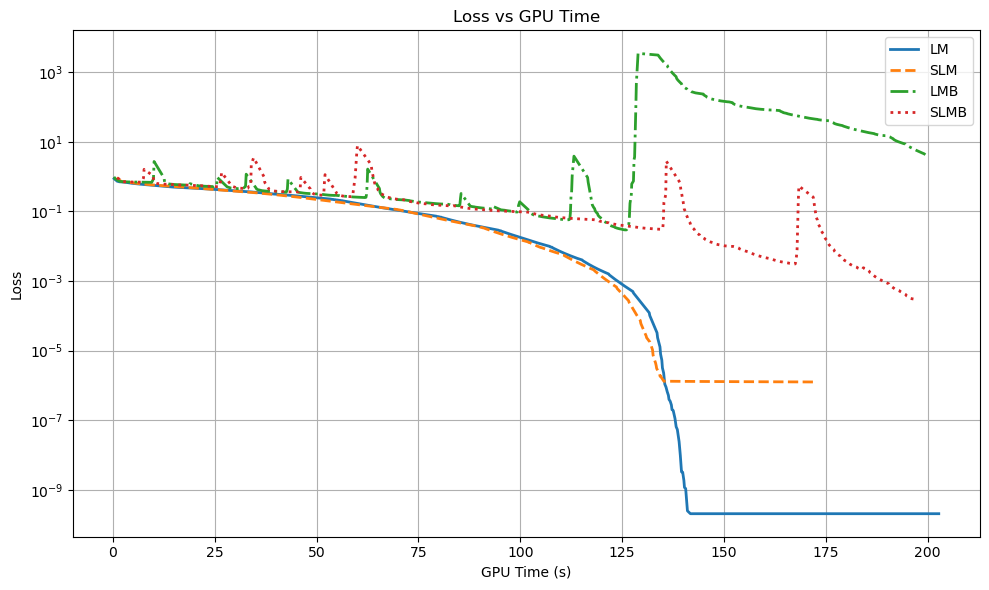

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],70, 70, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 2, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 2, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_csv("/home/zhy/Zhou/lm/wine/winequality-white.csv", sep=';') 

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=5880, step=1400,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=5880, step=1400,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=5880, step=1400,bd_tol=1,zone=2/3)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=5880, step=1400,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

[[0.13787014]
 [0.13787014]
 [0.13787014]
 ...
 [0.13787014]
 [1.2671142 ]
 [0.13787014]]
torch.Size([4898, 11])
model # of parameters: 5880
[1] Accept | Loss = 1.003659 -> 0.947497 | parameter #: 5880| time: 0


<ipython-input-4-3bd1627c78cb>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-4-3bd1627c78cb>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

[2] Reject
[3] Accept | Loss = 0.947497 -> 0.891482 | parameter #: 5880| time: 308.7554626464844
[4] Reject
[5] Accept | Loss = 0.891482 -> 0.835569 | parameter #: 5880| time: 582.719482421875
[6] Reject
[7] Accept | Loss = 0.835569 -> 0.791747 | parameter #: 5880| time: 860.1815185546875
[8] Accept | Loss = 0.791747 -> 0.750939 | parameter #: 5880| time: 999.5755615234375
[9] Reject
[10] Accept | Loss = 0.750939 -> 0.731969 | parameter #: 5880| time: 1280.0450439453125
[11] Accept | Loss = 0.731969 -> 0.722208 | parameter #: 5880| time: 1419.9818115234375
[12] Accept | Loss = 0.722208 -> 0.717975 | parameter #: 5880| time: 1561.6614990234375
[13] Accept | Loss = 0.717975 -> 0.713691 | parameter #: 5880| time: 1700.7196044921875
[14] Reject
[15] Reject
[16] Accept | Loss = 0.713691 -> 0.710463 | parameter #: 5880| time: 2119.488525390625
[17] Accept | Loss = 0.710463 -> 0.704538 | parameter #: 5880| time: 2260.998046875
[18] Reject
[19] Reject
[20] Accept | Loss = 0.704538 -> 0.698532 

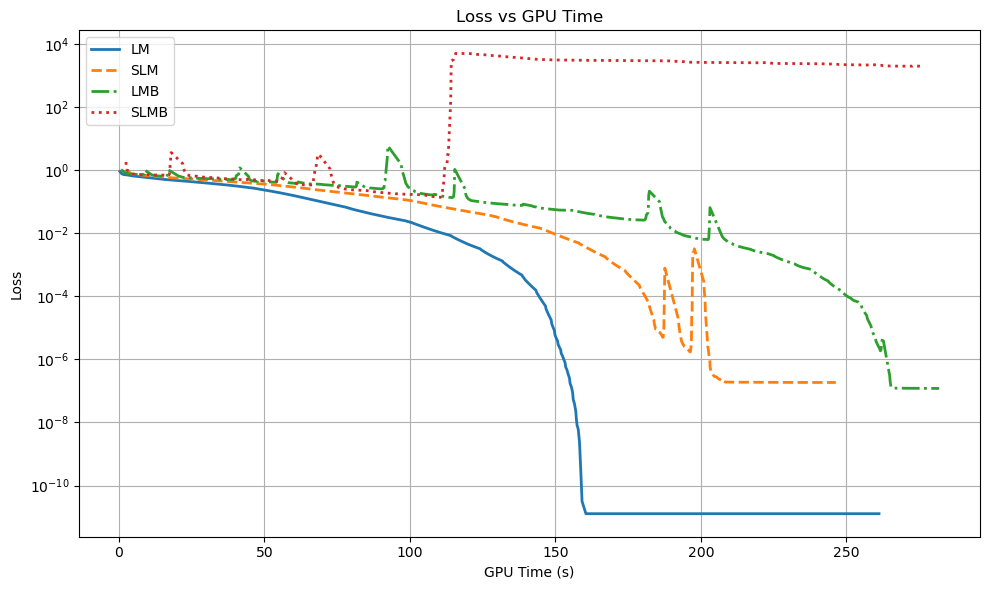

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],70, 70, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 2, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 2, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_csv("/home/zhy/Zhou/lm/wine/winequality-white.csv", sep=';') 

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=5880, step=1400,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=5880, step=1400,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=5880, step=1400,bd_tol=1,zone=2/3)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=5880, step=1400,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

[[0.13787014]
 [0.13787014]
 [0.13787014]
 ...
 [0.13787014]
 [1.2671142 ]
 [0.13787014]]
torch.Size([4898, 11])
model # of parameters: 5880
[1] Reject


<ipython-input-5-3bd1627c78cb>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-5-3bd1627c78cb>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

[2] Reject
[3] Reject
[4] Reject
[5] Accept | Loss = 1.317815 -> 0.989657 | parameter #: 5880| time: 548.8814086914062
[6] Accept | Loss = 0.989657 -> 0.973160 | parameter #: 5880| time: 684.1282348632812
[7] Accept | Loss = 0.973160 -> 0.954774 | parameter #: 5880| time: 820.3489379882812
[8] Accept | Loss = 0.954774 -> 0.922850 | parameter #: 5880| time: 953.4157104492188
[9] Accept | Loss = 0.922850 -> 0.871182 | parameter #: 5880| time: 1086.761962890625
[10] Reject
[11] Accept | Loss = 0.871182 -> 0.820775 | parameter #: 5880| time: 1354.902587890625
[12] Reject
[13] Accept | Loss = 0.820775 -> 0.784457 | parameter #: 5880| time: 1626.2850341796875
[14] Accept | Loss = 0.784457 -> 0.751232 | parameter #: 5880| time: 1762.8323974609375
[15] Reject
[16] Accept | Loss = 0.751232 -> 0.734962 | parameter #: 5880| time: 2036.8670654296875
[17] Accept | Loss = 0.734962 -> 0.725685 | parameter #: 5880| time: 2172.927978515625
[18] Accept | Loss = 0.725685 -> 0.721383 | parameter #: 5880| 

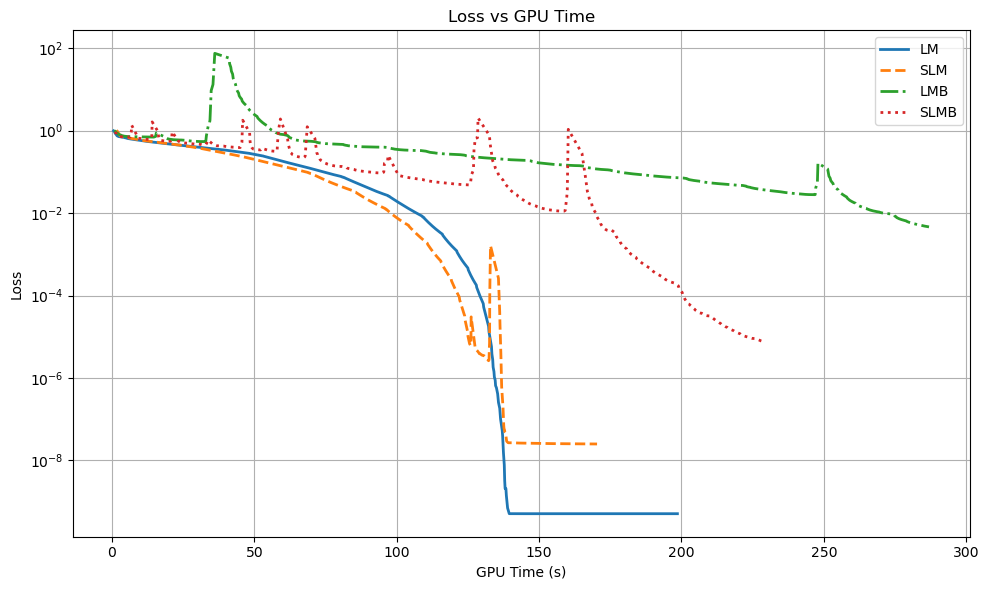

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],70, 70, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 2, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 2, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_csv("/home/zhy/Zhou/lm/wine/winequality-white.csv", sep=';') 

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=5880, step=1400,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=5880, step=1400,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=5880, step=1400,bd_tol=1,zone=2/3)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=5880, step=1400,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

[[0.13787014]
 [0.13787014]
 [0.13787014]
 ...
 [0.13787014]
 [1.2671142 ]
 [0.13787014]]
torch.Size([4898, 11])
model # of parameters: 5880
[1] Reject


<ipython-input-6-3bd1627c78cb>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-6-3bd1627c78cb>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

[2] Reject
[3] Reject
[4] Reject
[5] Accept | Loss = 1.226823 -> 0.986646 | parameter #: 5880| time: 712.2759399414062
[6] Accept | Loss = 0.986646 -> 0.971158 | parameter #: 5880| time: 909.3447875976562
[7] Accept | Loss = 0.971158 -> 0.951392 | parameter #: 5880| time: 1120.8017578125
[8] Accept | Loss = 0.951392 -> 0.916901 | parameter #: 5880| time: 1334.276123046875
[9] Accept | Loss = 0.916901 -> 0.861568 | parameter #: 5880| time: 1546.6475830078125
[10] Reject
[11] Accept | Loss = 0.861568 -> 0.810379 | parameter #: 5880| time: 1983.4378662109375
[12] Reject
[13] Accept | Loss = 0.810379 -> 0.775149 | parameter #: 5880| time: 2429.021240234375
[14] Accept | Loss = 0.775149 -> 0.744595 | parameter #: 5880| time: 2650.9423828125
[15] Reject
[16] Accept | Loss = 0.744595 -> 0.730661 | parameter #: 5880| time: 3097.134033203125
[17] Accept | Loss = 0.730661 -> 0.722846 | parameter #: 5880| time: 3317.3955078125
[18] Accept | Loss = 0.722846 -> 0.719126 | parameter #: 5880| time: 3

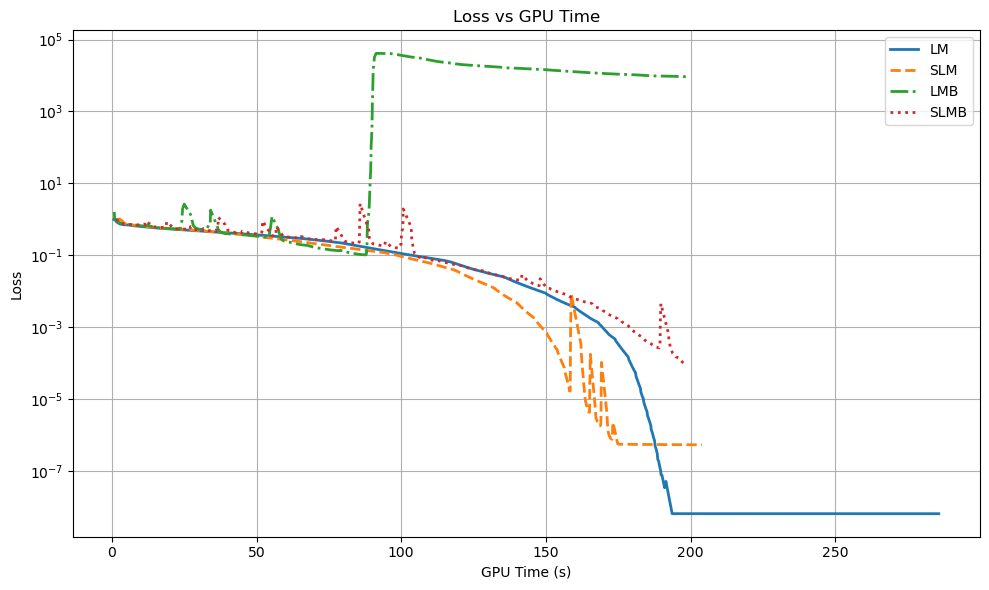

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],70, 70, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 2, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 2, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_csv("/home/zhy/Zhou/lm/wine/winequality-white.csv", sep=';') 

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=5880, step=1400,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=5880, step=1400,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=5880, step=1400,bd_tol=1,zone=2/3)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=5880, step=1400,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

[[0.13787014]
 [0.13787014]
 [0.13787014]
 ...
 [0.13787014]
 [1.2671142 ]
 [0.13787014]]
torch.Size([4898, 11])
model # of parameters: 5880
[1] Reject


<ipython-input-7-3bd1627c78cb>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-7-3bd1627c78cb>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

[2] Reject
[3] Reject
[4] Reject
[5] Accept | Loss = 1.203324 -> 0.984470 | parameter #: 5880| time: 577.0690307617188
[6] Accept | Loss = 0.984470 -> 0.972330 | parameter #: 5880| time: 715.2711791992188
[7] Accept | Loss = 0.972330 -> 0.957715 | parameter #: 5880| time: 856.23193359375
[8] Accept | Loss = 0.957715 -> 0.930143 | parameter #: 5880| time: 997.296142578125
[9] Accept | Loss = 0.930143 -> 0.879625 | parameter #: 5880| time: 1140.0499267578125
[10] Reject
[11] Accept | Loss = 0.879625 -> 0.824013 | parameter #: 5880| time: 1424.9144287109375
[12] Reject
[13] Accept | Loss = 0.824013 -> 0.783453 | parameter #: 5880| time: 1711.362060546875
[14] Accept | Loss = 0.783453 -> 0.748374 | parameter #: 5880| time: 1855.73583984375
[15] Reject
[16] Accept | Loss = 0.748374 -> 0.731846 | parameter #: 5880| time: 2140.3955078125
[17] Accept | Loss = 0.731846 -> 0.722078 | parameter #: 5880| time: 2293.4365234375
[18] Accept | Loss = 0.722078 -> 0.717305 | parameter #: 5880| time: 245

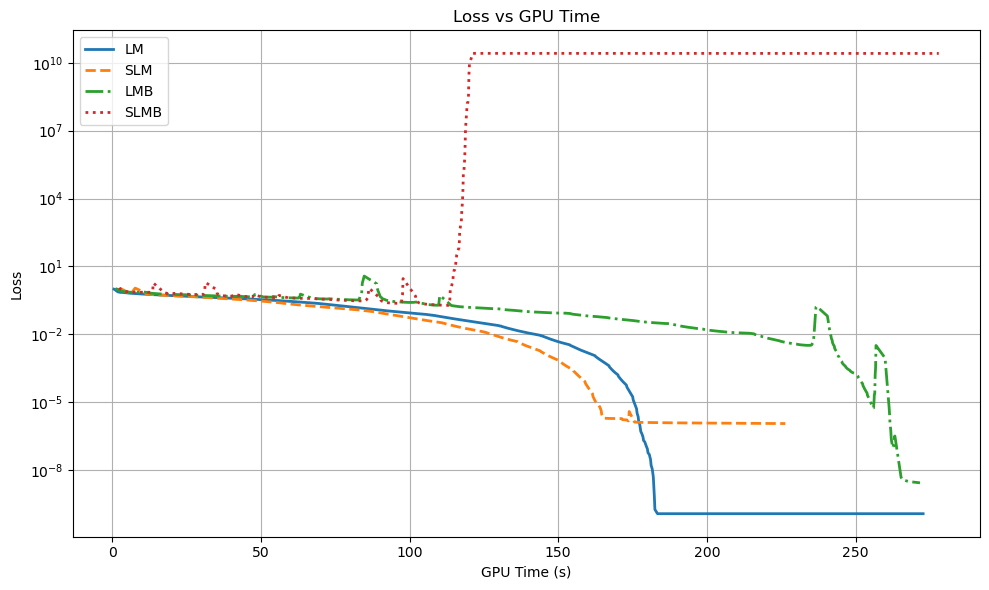

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],70, 70, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 2, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 2, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_csv("/home/zhy/Zhou/lm/wine/winequality-white.csv", sep=';') 

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=5880, step=1400,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=5880, step=1400,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=5880, step=1400,bd_tol=1,zone=2/3)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=5880, step=1400,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )